In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading Using Ensemble Strategy

Tutorials to use OpenAI DRL to trade multiple stocks using ensemble strategy in one Jupyter Notebook | Presented at ICAIF 2020

* This notebook is the reimplementation of our paper: Deep Reinforcement Learning for Automated Stock Trading: An Ensemble Strategy, using FinRL.
* Check out medium blog for detailed explanations: https://medium.com/@ai4finance/deep-reinforcement-learning-for-automated-stock-trading-f1dad0126a02
* Please report any issues to our Github: https://github.com/AI4Finance-LLC/FinRL-Library/issues
* **Pytorch Version**



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)             

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [2]:
# ## install finrl library
!pip install wrds
!pip install swig
!pip install -q condacolab
import condacolab
condacolab.install()
!apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git


  Using cached swig-4.3.1-py3-none-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (3.5 kB)
Using cached swig-4.3.1-py3-none-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.9 MB)
✨🍰✨ Everything looks OK!
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /tmp/pip-req-build-57n9a8zo
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /tmp/pip-req-build-57n9a8zo
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit 9175621d1235a335a667ee4796d7722e555a9e78
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-5chnpzw0/elegantrl_76c505aeb62d4616964


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them.
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
!pip install pandas_market_calendars

In [5]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

/usr/local/lib/python3.11/dist-packages/pandas_datareader/compat/__init__.py:11: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  PANDAS_VERSION = LooseVersion(pd.__version__)


<a id='1.4'></a>
## 2.4. Create Folders

In [6]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [7]:
print(DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [8]:
# TRAIN_START_DATE = '2009-04-01'
# TRAIN_END_DATE = '2021-01-01'
# TEST_START_DATE = '2021-01-01'
# TEST_END_DATE = '2022-06-01'

TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2021-10-01'
TEST_START_DATE = '2021-10-01'
TEST_END_DATE = '2023-03-01'

df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DOW_30_TICKER).fetch_data()

YF deprecation warning: set proxy via new config function: yf.set_config(proxy=proxy)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Shape of DataFrame:  (97013, 8)


In [9]:
df.head()

Price,date,close,high,low,open,volume,tic,day
0,2010-01-04,6.440332,6.455078,6.391279,6.422878,493729600,AAPL,0
1,2010-01-04,40.265968,40.370608,39.456742,39.505575,5277400,AMGN,0
2,2010-01-04,32.720367,32.864299,32.296571,32.632412,6894300,AXP,0
3,2010-01-04,43.777542,43.941181,42.702194,43.419094,6186700,BA,0
4,2010-01-04,39.547813,39.980103,38.845341,38.939907,7325600,CAT,0


In [10]:
df.tail()

Price,date,close,high,low,open,volume,tic,day
97008,2023-02-28,459.688324,466.854941,457.737310,466.188529,3902100,UNH,1
97009,2023-02-28,216.611618,218.413926,216.178274,216.670708,5385400,V,1
97010,2023-02-28,33.294487,33.431748,33.071435,33.200119,16685300,VZ,1
97011,2023-02-28,31.044868,31.263310,30.861379,31.001181,8847000,WBA,1
97012,2023-02-28,45.985912,46.154156,45.604125,45.620302,18054000,WMT,1


In [11]:
df.shape

(97013, 8)

In [12]:
df.sort_values(['date','tic']).head()

Price,date,close,high,low,open,volume,tic,day
0,2010-01-04,6.440332,6.455078,6.391279,6.422878,493729600,AAPL,0
1,2010-01-04,40.265968,40.370608,39.456742,39.505575,5277400,AMGN,0
2,2010-01-04,32.720367,32.864299,32.296571,32.632412,6894300,AXP,0
3,2010-01-04,43.777542,43.941181,42.702194,43.419094,6186700,BA,0
4,2010-01-04,39.547813,39.980103,38.845341,38.939907,7325600,CAT,0


In [13]:
len(df.tic.unique())

30

In [14]:
df.tic.value_counts()

,count
tic,
AAPL,3311
AMGN,3311
AXP,3311
BA,3311
CAT,3311
CRM,3311
CSCO,3311
CVX,3311
DIS,3311


# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [15]:
#  INDICATORS = ['macd',
#                'rsi_30',
#                'cci_30',
#                'dx_30']

In [16]:
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df)
processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)

Successfully added technical indicators
Successfully added turbulence index


In [17]:
processed.sample(5)

,date,close,high,low,open,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
64581,2018-11-05,58.627361,58.795975,57.938230,58.356106,6061200,WBA,0,1.366803,59.777346,52.229744,64.156618,141.233306,22.081761,55.214711,53.087102,45.857323
3739,2010-07-08,17.252565,17.326189,16.780144,16.853768,11703400,WBA,3,-0.805081,19.037673,15.542314,39.344966,-55.490235,13.705231,17.964062,19.773754,0.000000
87317,2021-12-16,40.601040,41.334598,39.974635,39.974635,5551900,WBA,3,0.391563,42.014266,36.192603,53.783562,67.845476,19.739546,39.528768,39.355493,59.555911
89856,2022-04-25,170.243484,170.865854,166.664913,166.884561,11176500,JNJ,0,2.391895,169.830595,160.260259,61.612484,155.376197,41.833659,163.459471,158.382308,48.124360
29278,2014-01-07,71.831810,72.353522,71.645486,71.831810,4881800,MCD,1,0.096118,72.821573,70.139242,51.153029,24.204773,4.035993,71.707190,71.440975,27.901501


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

In [18]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 29, State Space: 291


In [19]:
env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
    "print_verbosity":5

}

<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

* In this notebook, we are training and validating 3 agents (A2C, PPO, DDPG) using Rolling-window Ensemble Method ([reference code](https://github.com/AI4Finance-LLC/Deep-Reinforcement-Learning-for-Automated-Stock-Trading-Ensemble-Strategy-ICAIF-2020/blob/80415db8fa7b2179df6bd7e81ce4fe8dbf913806/model/models.py#L92))

In [20]:
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)

ensemble_agent = DRLEnsembleAgent(df=processed,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TEST_START_DATE,TEST_END_DATE),
                 rebalance_window=rebalance_window,
                 validation_window=validation_window,
                 **env_kwargs)



In [21]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.005,
                    'learning_rate': 0.0007
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 128
                    }

DDPG_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 10_000,
                      "learning_rate": 0.0005,
                      "batch_size": 64
                    }

SAC_model_kwargs = {
    "batch_size": 64,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

TD3_model_kwargs = {"batch_size": 100, "buffer_size": 1000000, "learning_rate": 0.0001}




timesteps_dict = {'a2c' : 10_000,
                 'ppo' : 10_000,
                 'ddpg' : 10_000,
                 'sac' : 10_000,
                 'td3' : 10_000
                 }

In [22]:
# 从已有训练结果加载df_summary
df_summary = ensemble_agent.run_ensemble_strategy(
    A2C_model_kwargs,
    PPO_model_kwargs,
    DDPG_model_kwargs,
    SAC_model_kwargs,
    TD3_model_kwargs,
    timesteps_dict,
)

============Start Ensemble Strategy============
turbulence_threshold:  201.71660380068985
======Model training from:  2010-01-01 to  2021-10-04
======a2c Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0007}
Using cuda device
Logging to tensorboard_log/a2c/a2c_126_1
----------------------------------------
| time/                 |              |
|    fps                | 91           |
|    iterations         | 100          |
|    time_elapsed       | 5            |
|    total_timesteps    | 500          |
| train/                |              |
|    entropy_loss       | -41.1        |
|    explained_variance | 0.0561       |
|    learning_rate      | 0.0007       |
|    n_updates          | 99           |
|    policy_loss        | -48.8        |
|    reward             | -0.053937014 |
|    std                | 0.999        |
|    value_loss         | 2.07         |
----------------------------------------
-------------------------------------
| time/          

In [23]:
df_summary

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe,SAC Sharpe,TD3 Sharpe
0,126,2021-10-04,2022-01-03,SAC,0.226315,-0.044229,0.204555,0.249651,-0.028362
1,189,2022-01-03,2022-04-04,TD3,-0.190262,-0.212394,-0.10655,-0.11103,0.110732
2,252,2022-04-04,2022-07-06,SAC,-0.197346,-0.256312,-0.199166,-0.129503,-0.189308
3,315,2022-07-06,2022-10-04,A2C,-0.029279,-0.208774,-0.078529,-0.165429,-0.069527


<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [24]:
unique_trade_date = processed[(processed.date > TEST_START_DATE)&(processed.date <= TEST_END_DATE)].date.unique()

In [25]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    # df_account_value = df_account_value.append(temp,ignore_index=True)
    df_account_value = pd.concat([df_account_value,temp], ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  -0.5356237677523193


In [26]:
df_account_value.head()

,account_value,date,daily_return,datadate
0,1.000000e+06,2022-01-03,NaN,2022-01-03
1,1.000879e+06,2022-01-04,0.000879,2022-01-04
2,9.906484e+05,2022-01-05,-0.010222,2022-01-05
3,9.840355e+05,2022-01-06,-0.006675,2022-01-06
4,9.827761e+05,2022-01-07,-0.001280,2022-01-07


<Axes: >

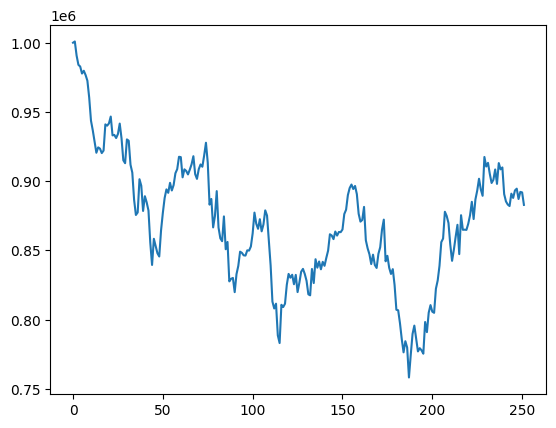

In [27]:
%matplotlib inline
df_account_value.account_value.plot()

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [28]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return         -0.117146
Cumulative returns    -0.117146
Annual volatility      0.197256
Sharpe ratio          -0.535624
Calmar ratio          -0.483162
Stability              0.199488
Max drawdown          -0.242456
Omega ratio            0.916206
Sortino ratio         -0.730032
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.955960
Daily value at risk   -0.025271
dtype: float64


In [29]:
#baseline stats
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI",
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(df_dji_, value_col_name = 'close')

==============Get Baseline Stats===========


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (251, 8)
Annual return         -0.094324
Cumulative returns    -0.093968
Annual volatility      0.198502
Sharpe ratio          -0.402058
Calmar ratio          -0.429901
Stability              0.236972
Max drawdown          -0.219408
Omega ratio            0.936015
Sortino ratio         -0.559755
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.014390
Daily value at risk   -0.025326
dtype: float64


In [30]:
df_dji = pd.DataFrame()
df_dji['date'] = df_account_value['date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji+.csv")

df_account_value.to_csv('df_account_value.csv')


df_dji:             date           dji
0    2022-01-03  1.000000e+06
1    2022-01-04  1.005866e+06
2    2022-01-05  9.951360e+05
3    2022-01-06  9.904718e+05
4    2022-01-07  9.903404e+05
..          ...           ...
247  2022-12-27  9.086102e+05
248  2022-12-28  8.986103e+05
249  2022-12-29  9.080428e+05
250  2022-12-30  9.060324e+05
251  2023-01-03           NaN

[252 rows x 2 columns]
df_dji:                       dji
date                    
2022-01-03  1.000000e+06
2022-01-04  1.005866e+06
2022-01-05  9.951360e+05
2022-01-06  9.904718e+05
2022-01-07  9.903404e+05
...                  ...
2022-12-27  9.086102e+05
2022-12-28  8.986103e+05
2022-12-29  9.080428e+05
2022-12-30  9.060324e+05
2023-01-03           NaN

[252 rows x 1 columns]


<a id='6.2'></a>
## 7.2 BackTestPlot

df_result_ensemble.columns:  Index(['ensemble'], dtype='object')
df_trade_date:         datadate
0    2021-10-04
1    2021-10-05
2    2021-10-06
3    2021-10-07
4    2021-10-08
..          ...
348  2023-02-22
349  2023-02-23
350  2023-02-24
351  2023-02-27
352  2023-02-28

[353 rows x 1 columns]
df_result_ensemble:                  ensemble
date                    
2022-01-03  1.000000e+06
2022-01-04  1.000879e+06
2022-01-05  9.906484e+05
2022-01-06  9.840355e+05
2022-01-07  9.827761e+05
...                  ...
2022-12-27  8.945753e+05
2022-12-28  8.871033e+05
2022-12-29  8.922576e+05
2022-12-30  8.918504e+05
2023-01-03  8.828544e+05

[252 rows x 1 columns]
==============Compare to DJIA===========
result:                  ensemble           dji
date                                  
2022-01-03  1.000000e+06  1.000000e+06
2022-01-04  1.000879e+06  1.005866e+06
2022-01-05  9.906484e+05  9.951360e+05
2022-01-06  9.840355e+05  9.904718e+05
2022-01-07  9.827761e+05  9.903404e+05
...       

<Figure size 1500x500 with 0 Axes>

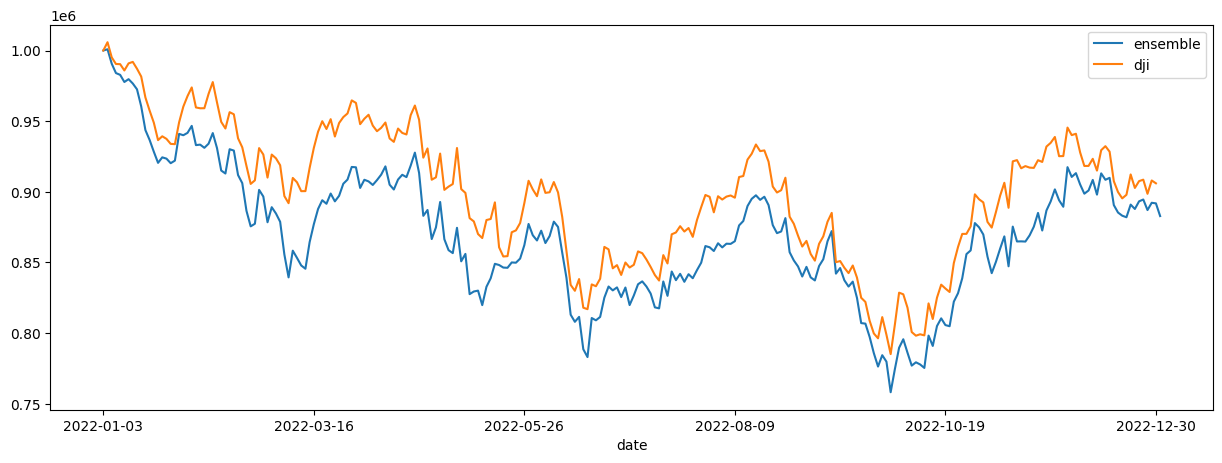

In [31]:


# print("==============Compare to DJIA===========")
# %matplotlib inline
# # S&P 500: ^GSPC
# # Dow Jones Index: ^DJI
# # NASDAQ 100: ^NDX
# backtest_plot(df_account_value,
#               baseline_ticker = '^DJI',
#               baseline_start = df_account_value.loc[0,'date'],
#               baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])
df.to_csv("df.csv")
df_result_ensemble = pd.DataFrame({'date': df_account_value['date'], 'ensemble': df_account_value['account_value']})
df_result_ensemble = df_result_ensemble.set_index('date')

print("df_result_ensemble.columns: ", df_result_ensemble.columns)

# df_result_ensemble.drop(df_result_ensemble.columns[0], axis = 1)
print("df_trade_date: ", df_trade_date)
# df_result_ensemble['date'] = df_trade_date['datadate']
# df_result_ensemble['account_value'] = df_account_value['account_value']
df_result_ensemble.to_csv("df_result_ensemble.csv")
print("df_result_ensemble: ", df_result_ensemble)
print("==============Compare to DJIA===========")
result = pd.DataFrame()
# result = pd.merge(result, df_result_ensemble, left_index=True, right_index=True)
# result = pd.merge(result, df_dji, left_index=True, right_index=True)
result = pd.merge(df_result_ensemble, df_dji, left_index=True, right_index=True)
print("result: ", result)
result.to_csv("result.csv")
result.columns = ['ensemble', 'dji']

%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();